# Load Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os
import re
import requests,io

#import astroalign

from astropy.io import fits
from astropy.stats import sigma_clipped_stats,gaussian_sigma_to_fwhm, SigmaClip
from astropy.table import QTable, Table
from astropy.utils.exceptions import AstropyDeprecationWarning


from photutils.background import LocalBackground, MMMBackground,Background2D,MedianBackground
from photutils.detection import DAOStarFinder
from photutils.psf import PSFPhotometry, IterativePSFPhotometry, IntegratedGaussianPRF,prepare_psf_model, IterativelySubtractedPSFPhotometry, DAOGroup, SourceGrouper
from shapely.geometry import LineString, Point
from scipy import interpolate

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from matplotlib.colors import LogNorm

# Load the reduced data

In [4]:
data_path = 'wednesday'

In [5]:
data = {}
data["M71B"] = np.load(f'{data_path}/M71B.npy')
data["M71V"] = np.load(f'{data_path}/M71G.npy')
data["M71R"] = np.load(f'{data_path}/M71R.npy')

In [6]:
for key, image in data.items():
    print(image.shape)

(1024, 1536)
(1024, 1536)
(1024, 1536)


In [7]:
error = {}
error["M71B"] = np.load(f'{data_path}/M71B_error.npy')
error["M71V"] = np.load(f'{data_path}/M71G_error.npy')[0]
error["M71R"] = np.load(f'{data_path}/M71R_error.npy')[0]

# Background Estimation


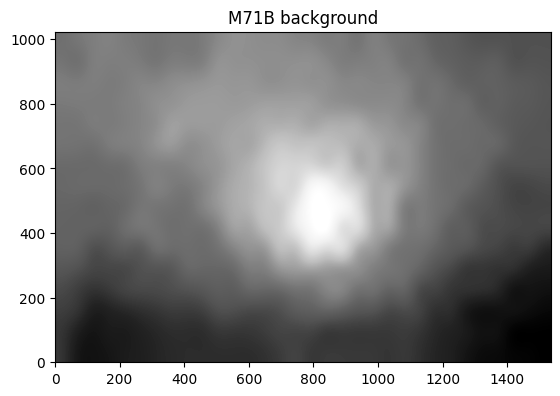

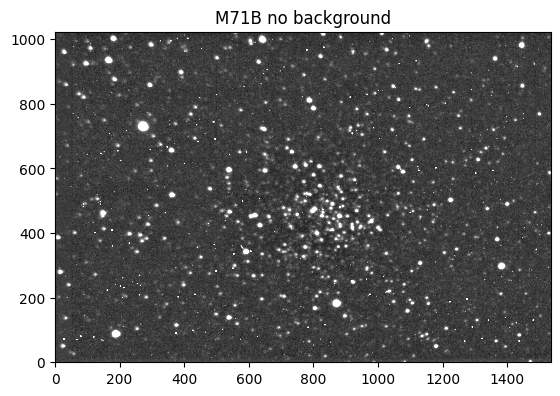

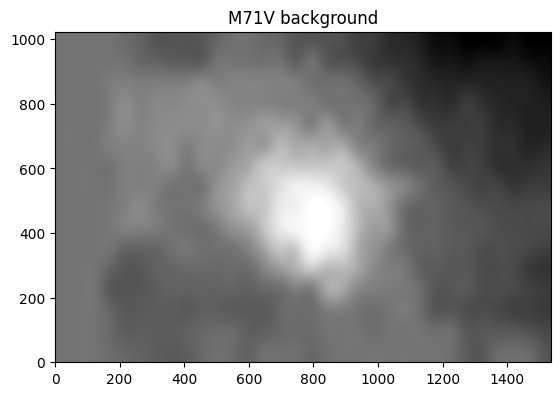

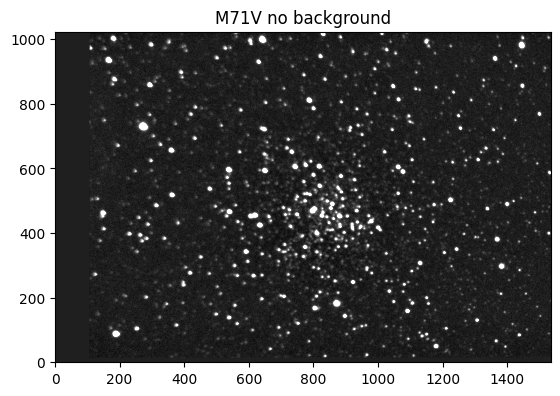

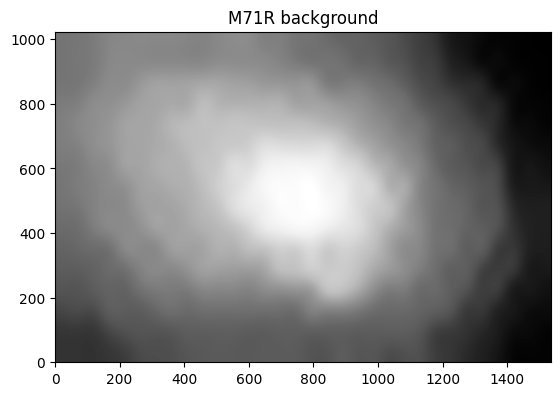

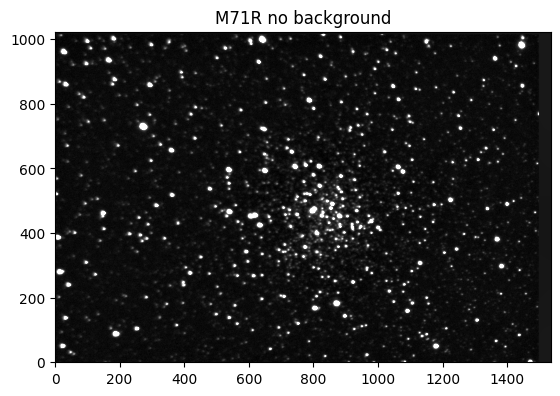

In [8]:
bkgs={}
bkg_uncs = {}
for key, image in data.items():
    sigma_clip = SigmaClip(sigma=3.0)
    bkg_estimator = MedianBackground()
    bkg = Background2D(image,
                       (64,48), #they say it works better if data is covered by int nb of boxes
                       filter_size=(3,3),sigma_clip=sigma_clip,
                    bkg_estimator=bkg_estimator)
    bkgs[key] = bkg.background
    bkg_uncs[key] = bkg.background_rms
    plt.title(f'{key} background')
    plt.imshow(bkg.background, origin='lower', cmap='Greys_r')
    plt.show()

    lo,up= np.percentile(image-bkg.background,1),np.percentile(image-bkg.background,99)
    plt.imshow(image-bkg.background, cmap='gray', origin='lower', clim=(lo,up))
    plt.title(f'{key} no background')
    plt.show()

    data[key] = image - bkg.background

# Get 2D FWHM

Found 2549 stars in image M71B


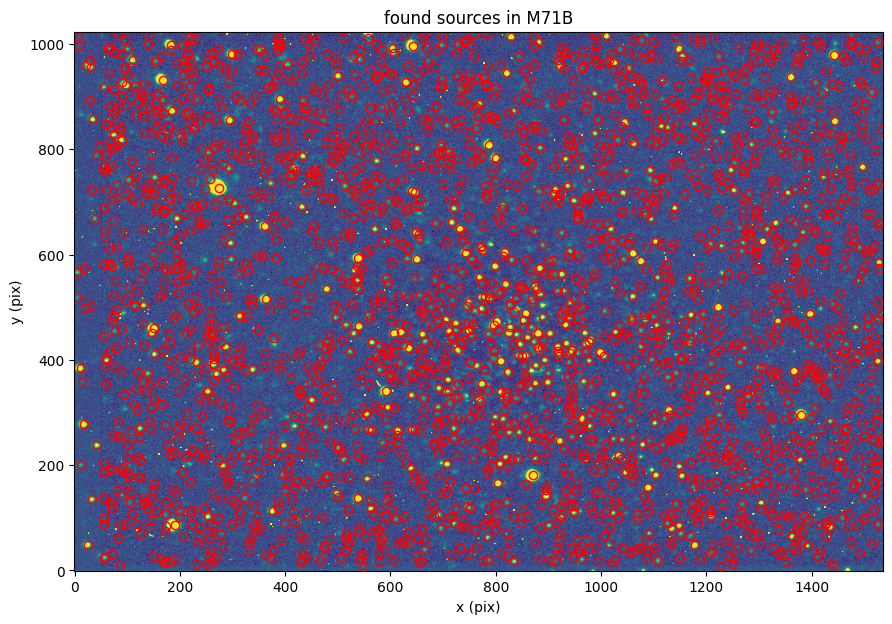

     x-FWHM 7.520484027309241+/-0.4995360319368272 (pix) for this M71B 
     y-FWHM 7.543236709437705+/-0.5430323491753691 (pix) for this M71B 
     FWHM 8.276898284693187+/-0.43044286096194867 (pix) for this M71B 
Found 4230 stars in image M71V


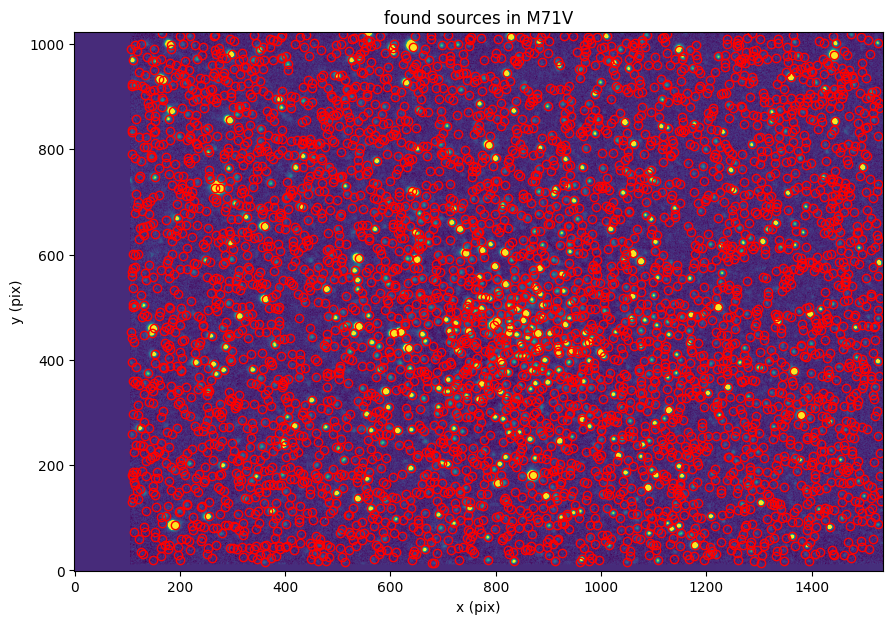

     x-FWHM 6.8283668985039725+/-0.4662818435820935 (pix) for this M71V 
     y-FWHM 6.7612038905394565+/-0.5070008354796839 (pix) for this M71V 
     FWHM 6.50358785502348+/-0.44311147045333255 (pix) for this M71V 
Found 3493 stars in image M71R


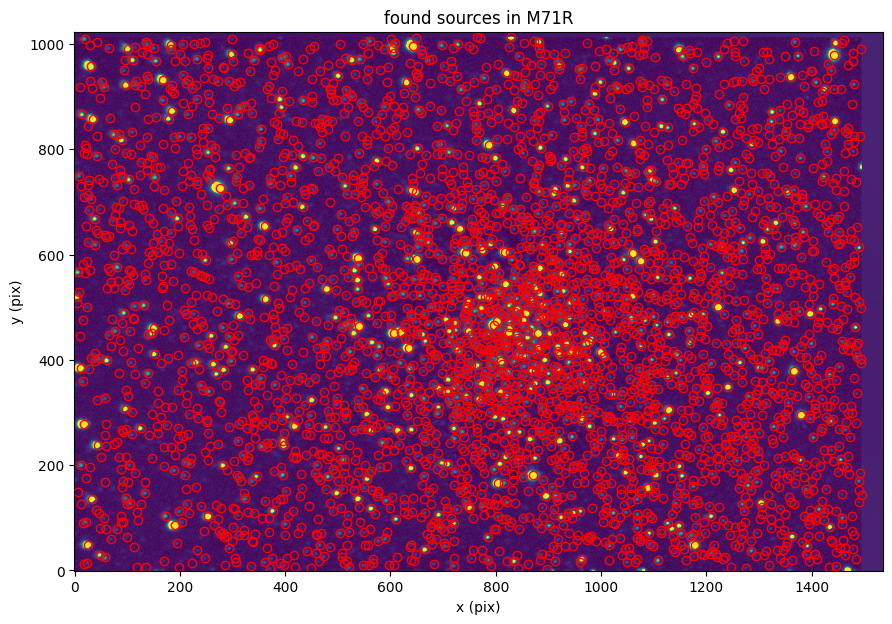

     x-FWHM 5.6895083308827+/-0.3156474364996052 (pix) for this M71R 
     y-FWHM 5.933875390511823+/-0.4152221573741772 (pix) for this M71R 
     FWHM 5.619374611719159+/-0.3555673008527254 (pix) for this M71R 


In [9]:
xfwhms = {}
yfwhms = {}
fwhms = {}
for key, image in data.items():
    mean, median, std = sigma_clipped_stats(image,sigma=3.0,maxiters=50)
    ## Find stars
    daofind = DAOStarFinder(fwhm=5.5, threshold=3.0*std, exclude_border= True)
    sources = daofind(image - median)
    print(f"Found {len(sources)} stars in image {key}")

    #Plot stars found
    fig = plt.figure(figsize=(12,7))
    l1 = np.percentile(image[np.isfinite(image)].flatten(), 1)
    l2 = np.percentile(image[np.isfinite(image)].flatten(), 99)
    plt.imshow(image,clim=(l1,l2),origin='lower')
    plt.plot(sources["xcentroid"],sources["ycentroid"],'or',mfc='none')
    plt.title(f"found sources in {key}")
    plt.xlabel("x (pix)")
    plt.ylabel("y (pix)")
    plt.show()

    ## Take nbright brightest stars 
    nbright = 5
    brightest = np.argsort(sources['flux'])[::-1][0:nbright]
    brsources = sources[brightest]

    ##########
    #get fwhm
    rmax = 25
    (ny,nx) = np.shape(image)
    from astropy.modeling import models,fitting
    fit_g = fitting.LevMarLSQFitter()
    allxfwhm, allyfwhm = np.zeros(len(brsources)),np.zeros(len(brsources))
    allfwhm,alltheta = np.zeros(len(brsources)),np.zeros(len(brsources))
    for i,src in enumerate(brsources):
        if int(src['ycentroid']) > rmax and int(src['ycentroid']) < ny-rmax and \
            int(src['xcentroid']) > rmax and int(src['xcentroid']) < nx-rmax:
            img = image[int(src['ycentroid'])-rmax:int(src['ycentroid'])+rmax,
                        int(src['xcentroid'])-rmax:int(src['xcentroid'])+rmax]
            subx,suby = np.indices(img.shape) # instead of meshgrid
            p_init = models.Gaussian2D(amplitude=np.max(img),x_mean=rmax,y_mean=rmax,x_stddev=1.0,y_stddev=1.0)
            fitgauss = fit_g(p_init, subx, suby, img - np.min(img))
            allxfwhm[i] = np.abs(fitgauss.x_stddev.value)
            allyfwhm[i] = np.abs(fitgauss.y_stddev.value)
            allfwhm[i] = 0.5*(allxfwhm[i]+allyfwhm[i])
            alltheta[i] = fitgauss.theta.value
    xfwhm,yfwhm = np.median(allxfwhm)*gaussian_sigma_to_fwhm,np.median(allyfwhm)*gaussian_sigma_to_fwhm
    fwhm = np.median(allfwhm)*gaussian_sigma_to_fwhm
    sigfwhm, sigxfwhm, sigyfwhm = np.std(allfwhm), np.std(allxfwhm), np.std(allyfwhm)
    medtheta = np.median(alltheta)
    print(f"     x-FWHM {xfwhm}+/-{sigxfwhm} (pix) for this {key} ")
    print(f"     y-FWHM {yfwhm}+/-{sigyfwhm} (pix) for this {key} ")
    print(f"     FWHM {fwhm}+/-{sigfwhm} (pix) for this {key} ")

    fwhms[key] = fwhm
    xfwhms[key] = xfwhm
    yfwhms[key] = yfwhm


# 2d gaussians

In [10]:
twodgauss = {}
psf_models = {}
for key, image in data.items():
    twodgauss[key] =  models.Gaussian2D(x_stddev=xfwhms[key]/gaussian_sigma_to_fwhm,
                                        y_stddev=yfwhms[key]/gaussian_sigma_to_fwhm,
                                        )
    
    #twodgauss[key].xname = 'x'
    #twodgauss[key].yname = 'y'
    #twodgauss[key].fluxname = 'amplitude'

    psf_models[key] = prepare_psf_model(twodgauss[key],xname='x_mean',yname='y_mean',fluxname='amplitude')
    

# Find point sources more accuretly with FWHM
more stars found this way:)

In [11]:
fwhms

{'M71B': 8.276898284693187,
 'M71V': 6.50358785502348,
 'M71R': 5.619374611719159}

Found 891 stars in image M71B


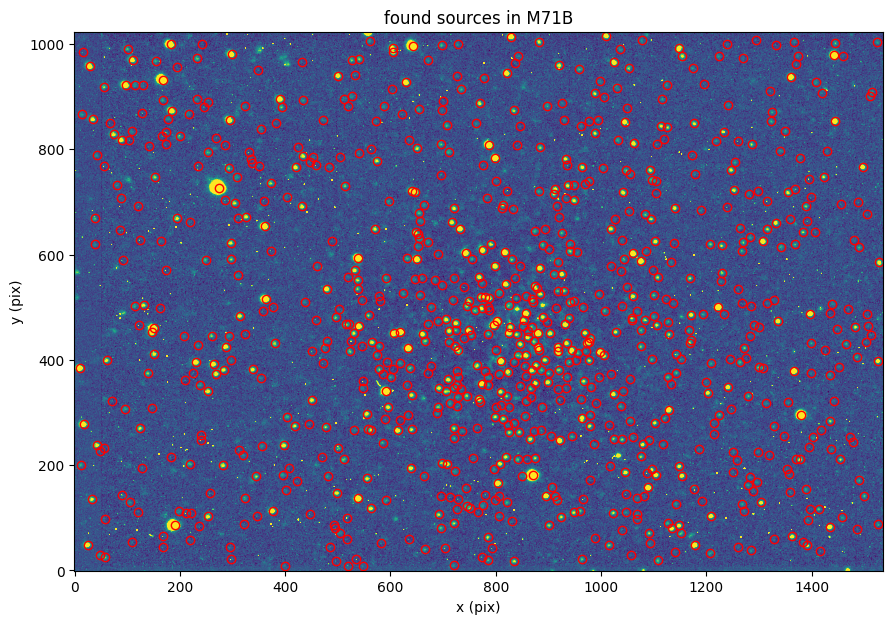

Found 728 stars in image M71V


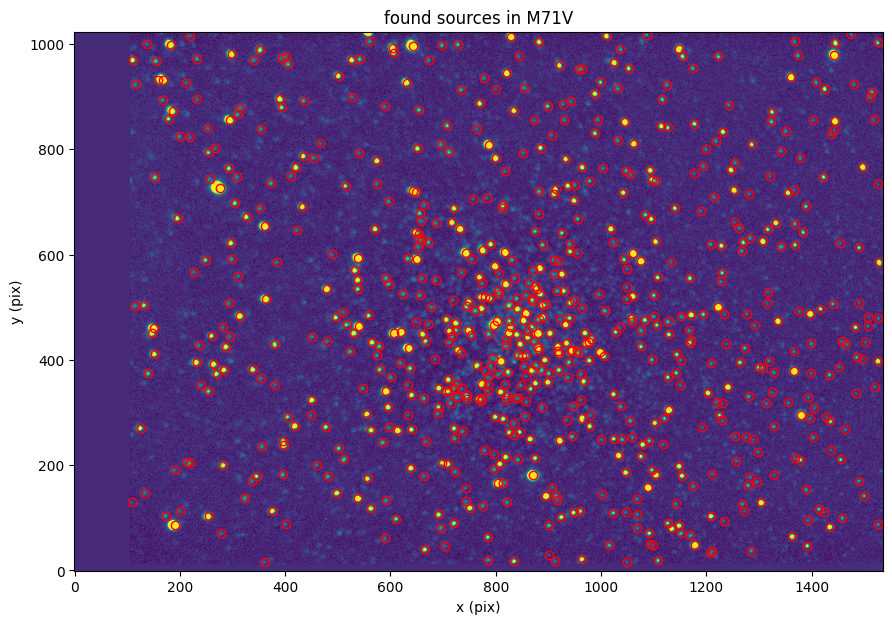

Found 596 stars in image M71R


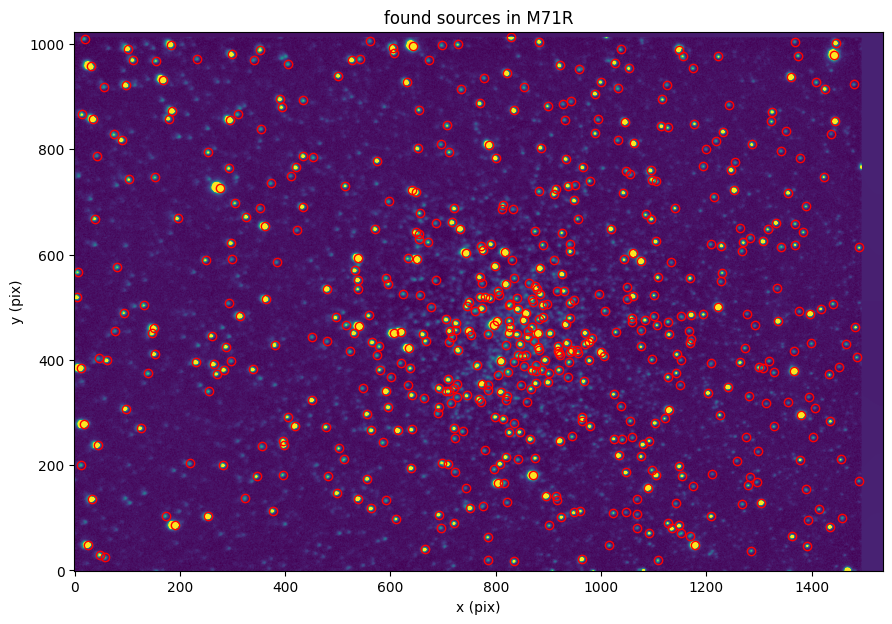

In [12]:
x_inits = {}
y_inits = {}

daofinds = {}

for key, image in data.items():

    mean, median, std = sigma_clipped_stats(image,sigma=100.0,maxiters=50)
    ## Find stars
    daofind = DAOStarFinder(fwhm=fwhms[key], threshold=0.8*std, exclude_border= True)
    sources = daofind(image - median)
    print(f"Found {len(sources)} stars in image {key}")

    daofinds[key]=daofind

    #Plot stars found
    fig = plt.figure(figsize=(12,7))
    l1 = np.percentile(image[np.isfinite(image)].flatten(), 1)
    l2 = np.percentile(image[np.isfinite(image)].flatten(), 99)
    plt.imshow(image,clim=(l1,l2),origin='lower')
    plt.plot(sources["xcentroid"],sources["ycentroid"],'or',mfc='none')
    plt.title(f"found sources in {key}")
    plt.xlabel("x (pix)")
    plt.ylabel("y (pix)")
    plt.show()

    ## Take nbright brightest stars and save
    nbright = 5
    brightest = np.argsort(sources['flux'])[::-1]#[0:nbright]
    brsources = sources[brightest]

    x_inits[key] = brsources['xcentroid']
    y_inits[key] = brsources['ycentroid']



# Iterative PSF Photometry :)

In [13]:
phots = {}

for key, image in data.items():

    group = SourceGrouper(fwhms[key])
    PSF = PSFPhotometry(
        grouper=group ,     
        psf_model=IntegratedGaussianPRF(sigma=fwhms[key]/gaussian_sigma_to_fwhm),
        finder=daofinds[key],
        fit_shape=(3,3), #play with this, this may be small
        aperture_radius=5 ,#play with this as well
        fitter_maxiters=500
    )
    init_params = QTable()
    init_params['x'] = x_inits[key]
    init_params['y'] = y_inits[key]

    phots[key] = PSF(image, 
                        init_params = init_params,
                        error=np.sqrt(np.square(bkg_uncs[key])+np.square(error[key])), 
                )

## See found stars 

<Figure size 640x480 with 0 Axes>

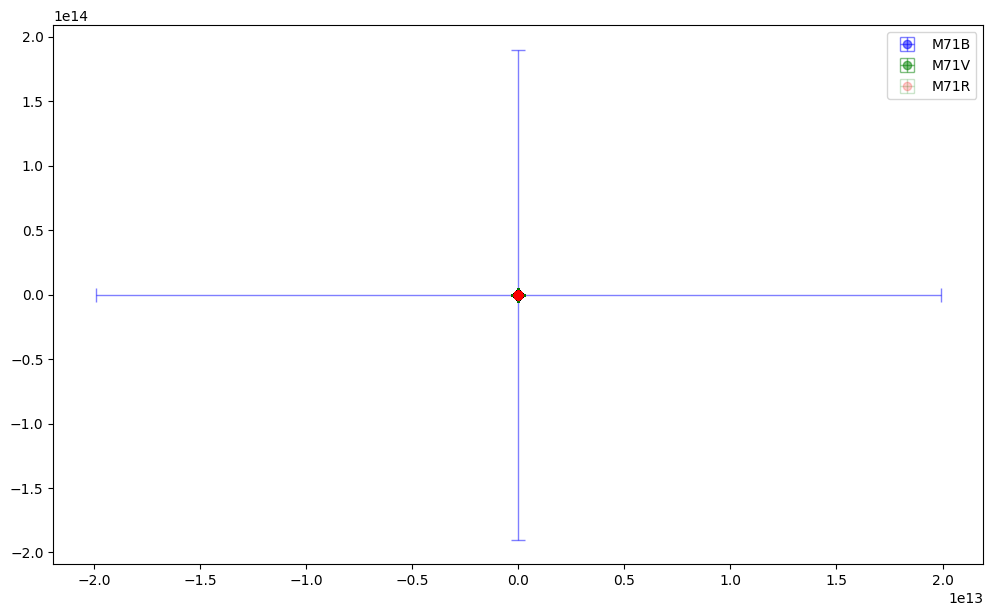

In [14]:

plt.clf()
fig = plt.figure(figsize=(12,7))
#plt.scatter(phots['M71B']['x_fit'],phots['M71B']['y_fit'], marker='o', c='blue', alpha=0.5)
#plt.scatter(phots['M71V']['x_fit'],phots['M71V']['y_fit'], marker='o', c='green',alpha=0.5)

plt.errorbar(x=phots['M71B']['x_fit'],y=phots['M71B']['y_fit'],
             xerr=phots['M71B']['x_err'],
             yerr=phots['M71B']['y_err'],fmt='o', ecolor='blue', elinewidth=1, capsize=5,c='blue',label="M71B",alpha=0.5
              )
plt.errorbar(x=phots['M71V']['x_fit'],y=phots['M71V']['y_fit'],
             xerr=phots['M71V']['x_err'],
             yerr=phots['M71V']['y_err'],fmt='o', ecolor='green', elinewidth=1, capsize=5,c='green',label="M71V",alpha=0.5
              )
plt.errorbar(x=phots['M71R']['x_fit'],y=phots['M71R']['y_fit'],
             xerr=phots['M71R']['x_err'],
             yerr=phots['M71R']['y_err'],fmt='o', ecolor='green', elinewidth=1, capsize=5,c='RED',label="M71R",alpha=0.2
              )

plt.legend()

plt.show()

## Create dataframe for both Filters

In [15]:
m71b = phots['M71B'].to_pandas()
m71v = phots['M71V'].to_pandas()
m71r = phots['M71R'].to_pandas()

In [16]:
# function to filter out some bad points

def clean_df(data, n=0):
    # Drop rows with missing values
    df = data.dropna(inplace=False)

    # Apply the initial filtering conditions
    cond = (df['flags'] == 0) & (df['x_fit'] > 0) & (df['x_fit'] < 1536) & (df['y_fit'] > 0) & (df['y_fit'] < 1024)
    filtered_df = df[cond].copy()

    # Keep only nth lines with the highest 'flux_fit'
    if n > 0:
        filtered_df = filtered_df.nlargest(n, 'flux_fit')

    return filtered_df

In [17]:
print(f"B : {m71b.shape}")
print(f"V : {m71v.shape}")
print(f"R : {m71r.shape}")


B : (891, 17)
V : (728, 17)
R : (596, 17)


In [18]:
m71b = clean_df(m71b)
m71v = clean_df(m71v)
m71r = clean_df(m71r)
print(f"B : {m71b.shape}")
print(f"V : {m71v.shape}")
print(f"R : {m71r.shape}")

B : (783, 17)
V : (728, 17)
R : (593, 17)


In [19]:
matched_indexes_b = []
matched_indexes_v = []
matched_indexes_r = []

dt_B = 90
dt_V = 60
dt_R = 60

margin = 4 #3 pixeis

dfs_to_concat = []

m71 = pd.DataFrame(columns = ["Bflux", "Vflux","Rflux","Bflux_err",'Vflux_err', 'Rflux_err'])
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    for i_m71v, row_m71v in m71v.iterrows():
        for i_m71b, row_m71b in m71b.iterrows():
            if abs(row_m71v['x_fit'] - row_m71b['x_fit']) < margin and abs(row_m71b['y_fit'] - row_m71v['y_fit']) < margin:
                #for i_m71r, row_m71r in m71r.iterrows():
                    #if abs(row_m71r['x_fit'] - row_m71b['x_fit']) < margin and abs(row_m71b['y_fit'] - row_m71r['y_fit']) < margin:
                df_to_append = pd.DataFrame({
                'Bflux': [row_m71b['flux_fit']/dt_B],
                'Vflux': [row_m71v['flux_fit']/dt_V],
                #'Rflux': [row_m71r['flux_fit']/dt_R],
                'Bflux_err': [row_m71b['flux_err']/dt_B],
                'Vflux_err': [row_m71v['flux_err']/dt_V],
                #'Rflux_err': [row_m71r['flux_err']/dt_R],
        
    })
                dfs_to_concat.append(df_to_append)

                if (i_m71v in matched_indexes_v) or (i_m71b in matched_indexes_b):
                    print(f"Something's wrong {i_m71v} {i_m71b}")
                matched_indexes_b.append(i_m71b)
                matched_indexes_v.append(i_m71v)

m71 = pd.concat(dfs_to_concat, ignore_index=True)

#m71b['flux_fit']
print(m71["Bflux"])

Something's wrong 339 86
Something's wrong 352 548
Something's wrong 410 469
Something's wrong 507 741
Something's wrong 691 766
0      7594.257348
1      3914.812644
2       738.251529
3      1223.411748
4      2290.528761
          ...     
516      20.964000
517      19.862014
518      13.887382
519      15.608097
520      20.373003
Name: Bflux, Length: 521, dtype: float64


In [20]:
m71.shape

(521, 4)

# HR Diagram Relative Magnitudes

<Figure size 640x480 with 0 Axes>

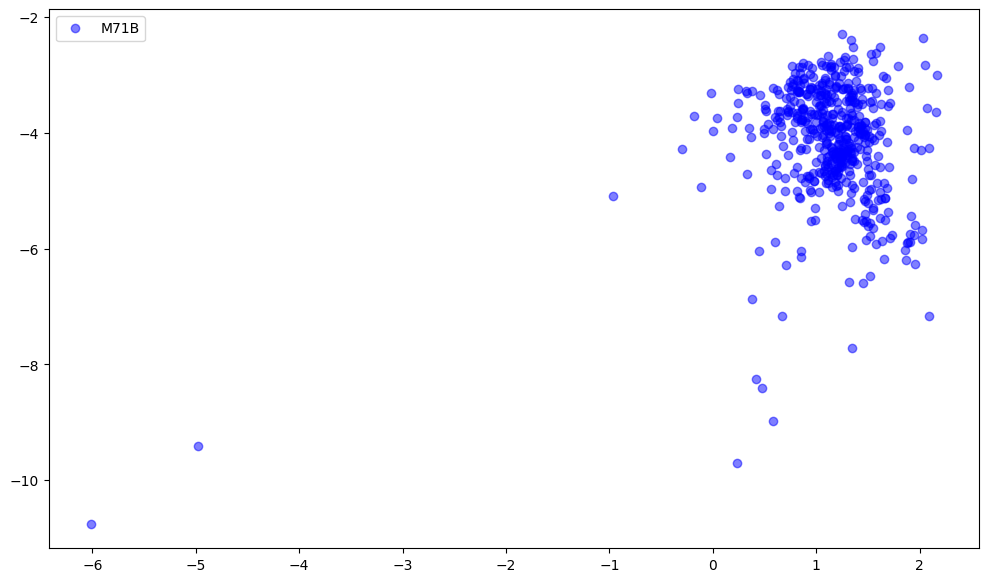

In [21]:

plt.clf()
fig = plt.figure(figsize=(12,7))

plt.errorbar(y=-2.5*np.log10(m71.Bflux),x=-2.5*np.log10(m71.Bflux/m71.Vflux),
             #xerr=phots['M71B']['x_err'],
             #yerr=phots['M71B']['y_err'],
             fmt='o', ecolor='blue', elinewidth=1, capsize=5,c='blue',label="M71B",alpha=0.5
              )

plt.legend()

plt.show()

In [22]:
def calc_m (flux):
    return -2.5 * np.log10(flux)

def calc_m_err(flux, flux_err):
    return abs(-2.5/(flux*np.log(10))*flux_err)

def calc_M (m,d):
    return m - 5*np.log10(d) + 5

def calc_M_err (m_err, d , d_err):
    return np.sqrt(m_err **2 + ((-5/(d *np.log(10)))*d_err)**2 )
    


# Correct to Distance + Standard Star

In [23]:
#Standard star hip100108
#https://simbad.cds.unistra.fr/simbad/sim-ref?bibcode=2020yCat.1350....0G
d_StStar = 159.872
d_StStar_err = 1.7866
M_abs_StStar_B_true = 5.703
M_abs_StStar_V_true = 5.592933

StStar_Bflux = 406095.45235442615
StStar_Bflux_err= 204228.08734797066

StStar_Vflux = 695162.3459242923 
StStar_Vflux_err = 16058.26689625473

StStar_Rflux = 878399.8630290579 
StStar_Rflux_err = 19291.720281169186


m_StStar_B = calc_m(StStar_Bflux) #+instrumental zero point
m_StStar_B_err = calc_m_err(flux=StStar_Bflux, flux_err=StStar_Bflux_err)

m_StStar_V = calc_m(StStar_Vflux) #+instrumental zero point
m_StStar_V_err = calc_m_err(flux=StStar_Vflux, flux_err=StStar_Vflux_err)

print(f"Standard Star mB = {m_StStar_B} +- {m_StStar_B_err}")
print(f"Standard Star mV = {m_StStar_V} +- {m_StStar_V_err}")


Standard Star mB = -14.021570315214646 +- 0.5460239142709539
Standard Star mV = -14.605215600344263 +- 0.02508053242117275


In [24]:
M_abs_StStar_B = calc_M(m=m_StStar_B,d=d_StStar)
M_abs_StStar_B_err = calc_M_err(m_err=m_StStar_B_err,d=d_StStar,d_err=d_StStar_err)

M_abs_StStar_V = calc_M(m=m_StStar_V,d=d_StStar)
M_abs_StStar_V_err = calc_M_err(m_err=m_StStar_V_err,d=d_StStar,d_err=d_StStar_err)

print(f"Standard Star MB = {M_abs_StStar_B} +- {M_abs_StStar_B_err}")
print(f"Standard Star MV = {M_abs_StStar_V} +- {M_abs_StStar_V_err}")



Standard Star MB = -20.04043235532467 +- 0.5465628817076709
Standard Star MV = -20.62407764045428 +- 0.03489844998490502


In [25]:
inst_calib_B = M_abs_StStar_B_true - M_abs_StStar_B
inst_calib_V = M_abs_StStar_V_true - M_abs_StStar_V

inst_calib_B_err = M_abs_StStar_B_err
inst_calib_V_err = M_abs_StStar_V_err

In [26]:
m71["mB"] = calc_m(flux=m71["Bflux"])
m71["mB_err"] = calc_m_err(flux=m71["Bflux"],flux_err=m71["Bflux_err"])

m71["mV"] = calc_m(flux=m71["Vflux"])
m71["mV_err"] = calc_m_err(flux=m71["Vflux"],flux_err=m71["Vflux_err"])

In [27]:
#https://simbad.cds.unistra.fr/simbad/sim-ref?bibcode=2021MNRAS.504..356D
d= 4000
d_err=100

MB_uncalib = calc_M(m=m71["mB"],d=d)
MB_uncalib_err = calc_M_err(m_err=m71["mB_err"],d=d,d_err=d_err)

MV_uncalib = calc_M(m=m71["mV"],d=d)
MV_uncalib_err = calc_M_err(m_err=m71["mV_err"],d=d,d_err=d_err)


In [28]:
m71["MB"] = inst_calib_B + MB_uncalib
m71["MB_err"] = np.sqrt( inst_calib_B_err**2 + MB_uncalib_err**2 )

m71["MV"] = inst_calib_V + MV_uncalib
m71["MV_err"] = np.sqrt( inst_calib_V_err**2 + MV_uncalib_err**2 )

In [29]:
print(np.mean(m71["MB"]))

8.590961146684997


In [30]:
m71["BV"] = m71["MB"] - m71["MV"]
m71["BV_err"] = np.sqrt( m71["MB_err"]**2 + m71["MV_err"]**2  )

<Figure size 640x480 with 0 Axes>

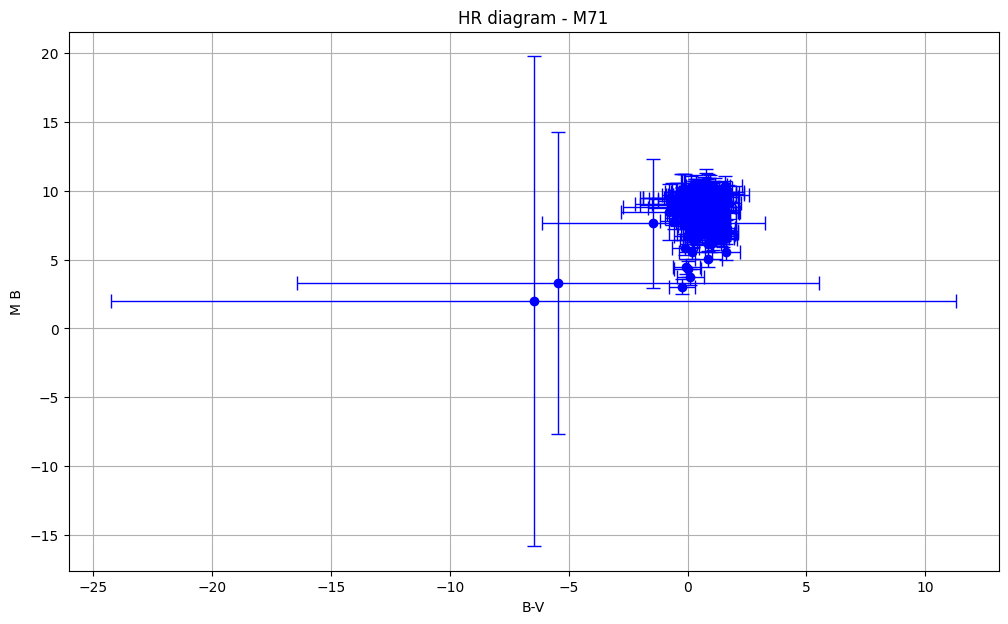

In [31]:
plt.clf()
fig = plt.figure(figsize=(12,7))
plt.errorbar(
    x=m71["BV"],
    y=m71["MB"],
    xerr=m71["BV_err"],
    yerr=m71["MB_err"],
    fmt='o', ecolor='blue', elinewidth=1, capsize=5,c='blue'
)
plt.xlabel('B-V')
plt.ylabel('M B')

plt.title("HR diagram - M71")
plt.grid(True)
plt.show()

In [32]:
m71["BV"] = -2.5*np.log10(m71["Bflux"]/m71["Vflux"])

m71["BV_err"] = np.sqrt( np.square( calc_m_err(m71["Bflux"],m71["Bflux_err"] ))  +  np.square( calc_m_err(m71["Vflux"],m71["Vflux_err"] )) )

# HR Diagram

<Figure size 640x480 with 0 Axes>

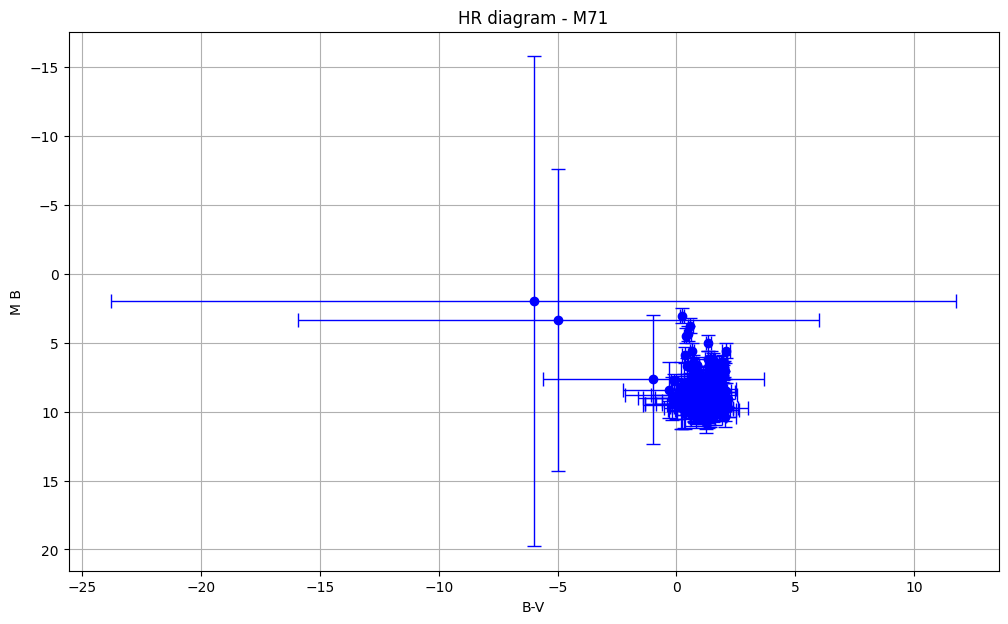

In [33]:
plt.clf()
fig = plt.figure(figsize=(12,7))
plt.errorbar(
    x=m71["BV"],
    y=m71["MB"],
    xerr=m71["BV_err"],
    yerr=m71["MB_err"],
    fmt='o', ecolor='blue', elinewidth=1, capsize=5,c='blue'
)
plt.xlabel('B-V')
plt.ylabel('M B')

plt.gca().invert_yaxis()

plt.title("HR diagram - M71")
plt.grid(True)
plt.show()

## Remove points w/ bigger uncertainties

<Figure size 640x480 with 0 Axes>

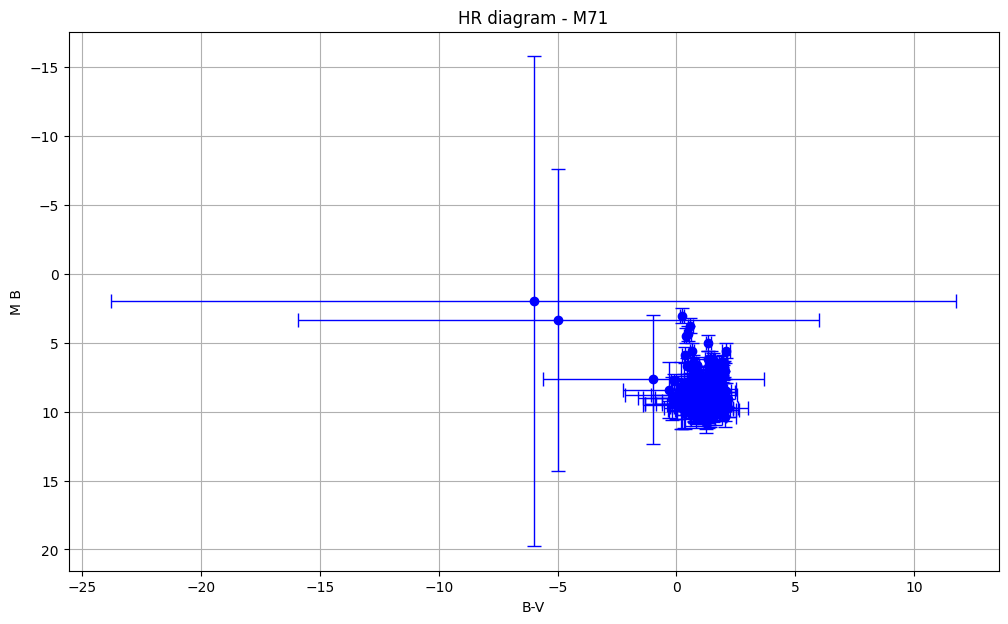

In [34]:
acc_MB = 0.6
acc_BV = 0.08
#condition to remove data point
#m71_new = m71[(m71['BV_err'] < acc_BV) & (m71['MB_err'] < acc_MB)]
m71_new = m71
m71_new = m71_new.reset_index(drop=True)

plt.clf()
fig = plt.figure(figsize=(12,7))
plt.errorbar(
    x=m71_new["BV"],
    y=m71_new["MB"],
    xerr=m71_new["BV_err"],
    yerr=m71_new["MB_err"],
    fmt='o', ecolor='blue', elinewidth=1, capsize=5,c='blue'
)
plt.xlabel('B-V')
plt.ylabel('M B')

plt.gca().invert_yaxis()

plt.title("HR diagram - M71")
plt.grid(True)
plt.show()


# Isochrone Fitting

In [36]:
#Read the models
#Important: Open the model file (in any text editor) and remove the # at the beginning of the line 13 (names of the columns)
#Otherwise python won't know the column names and will call them col1, col2 etc.
isochrones = Table.read('wednesday/m71_isochrones_fit.dat', format='ascii')
print(isochrones.columns)

#Let's see which ages we have in the model file
logages=np.unique(isochrones['logAge']) #find the unique age entries
ages=np.unique(10**isochrones['logAge']/1e9) #in Gyrs
for logage, age in zip(logages,ages): print(logage,age) #print all of that


# Create a mask to select isochrones with age less than or equal to 15
#mask = isochrones['logAge'] <= 10.09691   # Convert 15 Gyrs to logAge format

# Apply the mask to filter the isochrones table
#isochrones = isochrones[mask]

#for logage, age in zip(logages,ages): print(logage,age) #print all of that


<TableColumns names=('Zini','MH','logAge','Mini','int_IMF','Mass','logL','logTe','logg','label','McoreTP','C_O','period0','period1','pmode','Mloss','tau1m','X','Y','Xc','Xn','Xo','Cexcess','Z','mbolmag','Umag','Bmag','Vmag','Rmag','Imag','Jmag','Hmag','Kmag')>
8.0 0.1
8.54407 0.3500015760710141
8.77815 0.5999982725336439
8.92942 0.850002102591718
9.04139 1.099993198935193
9.13033 1.3499882857222538
9.20412 1.6000000638979344
9.26717 1.8499926373938749
9.32222 2.1000034102666123
9.37107 2.350011567436364
9.41497 2.599979956709246
9.45484 2.849968107016486
9.49136 3.0999879094111864
9.52504 3.3499629203570875
9.5563 3.5999792704335687
9.58546 3.8499935329471406
9.61278 4.099963590417653
9.63849 4.350007442530871
9.66276 4.600022966650687
9.68574 4.849980584132528
9.70757 5.099997932049961
9.72835 5.349953410125365
9.74819 5.600025440780003
9.76716 5.850055684645678
9.78533 6.100002317401106
9.80277 6.34994553119238
9.81954 6.599940191598727
9.83569 6.849990986022837
9.85126 7.10002699577

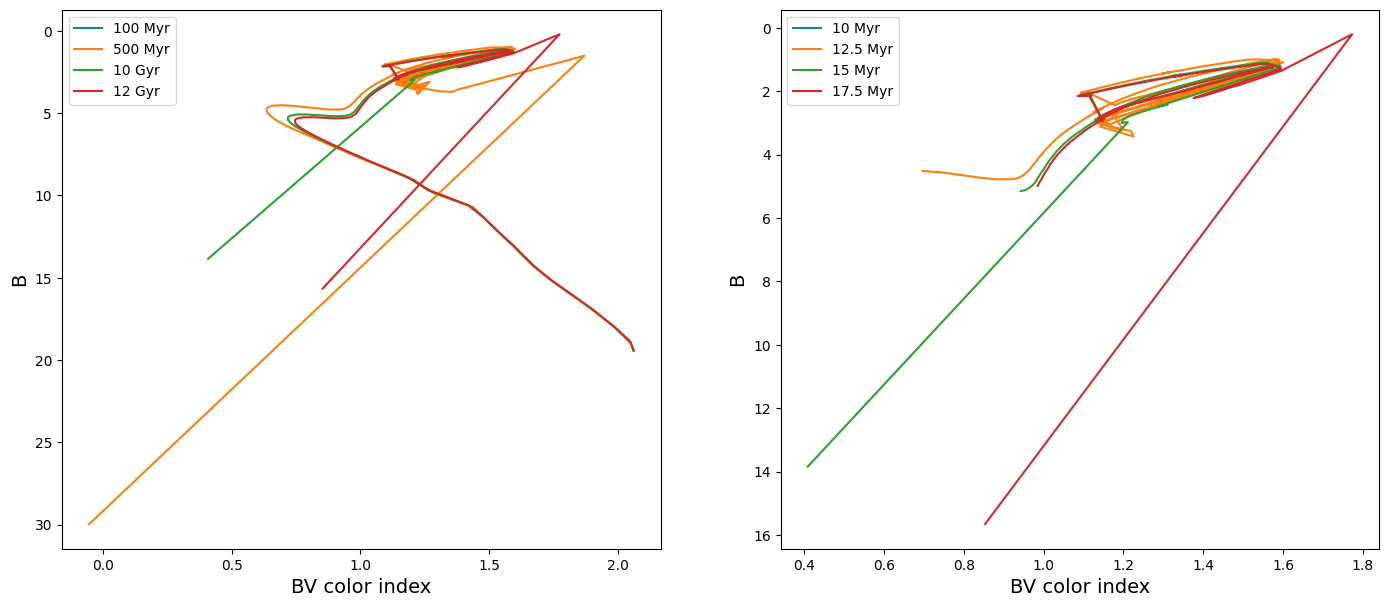

In [37]:
#you can select the isochrone with some particular age
age_1 = isochrones['logAge'] == 9.72016 #5
age_2 = isochrones['logAge'] == 9.95904 #9
age_3 = isochrones['logAge'] == 10.14922 #14
age_4 = isochrones['logAge'] == 10.20683 #16
age_5 = isochrones['logAge'] == 10.25768 #18
age_6 = isochrones['logAge'] == 10.29776 #20

fig,[ax1,ax2] = plt.subplots(nrows=1,ncols=2,figsize=(17,7))
ax1.plot(isochrones['Bmag'][age_1] - isochrones['Vmag'][age_1], isochrones['Bmag'][age_1],label='100 Myr')
ax1.plot(isochrones['Bmag'][age_2] - isochrones['Vmag'][age_2], isochrones['Bmag'][age_2],label='500 Myr')
ax1.plot(isochrones['Bmag'][age_3] - isochrones['Vmag'][age_3], isochrones['Bmag'][age_3],label='10 Gyr')
ax1.plot(isochrones['Bmag'][age_4] - isochrones['Vmag'][age_4], isochrones['Bmag'][age_4],label='12 Gyr')
ax1.invert_yaxis()
ax1.set_xlabel('BV color index',fontsize=14)
ax1.set_ylabel('B',fontsize=14)
ax1.legend()

#We can cut off the more evolved stages
N_MIN = 50
N_MAX = 250
ax2.plot(isochrones['Bmag'][age_1][N_MIN:N_MAX] - isochrones['Vmag'][age_1][N_MIN:N_MAX], isochrones['Bmag'][age_1][N_MIN:N_MAX],label='10 Myr')
ax2.plot(isochrones['Bmag'][age_2][N_MIN:N_MAX] - isochrones['Vmag'][age_2][N_MIN:N_MAX], isochrones['Bmag'][age_2][N_MIN:N_MAX],label='12.5 Myr')
ax2.plot(isochrones['Bmag'][age_3][N_MIN:N_MAX] - isochrones['Vmag'][age_3][N_MIN:N_MAX], isochrones['Bmag'][age_3][N_MIN:N_MAX],label='15 Myr')
ax2.plot(isochrones['Bmag'][age_4][N_MIN:N_MAX] - isochrones['Vmag'][age_4][N_MIN:N_MAX], isochrones['Bmag'][age_4][N_MIN:N_MAX],label='17.5 Myr')
ax2.invert_yaxis()
ax2.set_xlabel('BV color index',fontsize=14)
ax2.set_ylabel('B',fontsize=14)
ax2.legend()

# Deleting some points that might be making our results worst
In this case Im only deleting the points with B - V < 2 that have very big uncertainties

In [38]:
m71_new1 = m71_new.sort_values(by='MB', ascending=True)
#print(m71_new1[['MB', 'BV']])

def drop_points(df, MB_value, BV_value):
    tolerance = 1e-1  # Define a small tolerance for comparisons
    mask = ((df['MB'] >= MB_value - tolerance) & (df['MB'] <= MB_value + tolerance) & (df['BV'] >= BV_value - tolerance) & (df['BV'] <= BV_value + tolerance))
    df = df[~mask]
    df = df.reset_index(drop=True)
    return df

m71_new1 = m71_new1[(m71_new1['BV'] > - 2)]
m71_new1 = m71_new1.reset_index(drop=True)
#m71_new1 = drop_points(m71_new1, 6.854423, 0.600032)
#m71_new1 = drop_points(m71_new1, 7.467291, 0.600032)
#m71_new1 = drop_points(m71_new1, 7.962470, 0.693243)
#m71_new1 = drop_points(m71_new1, 8.469973, 0.848594)

print(m71_new1[['MB', 'BV']])

            MB        BV
0     3.031919  0.234852
1     3.751355  0.584627
2     4.333293  0.474757
3     4.484937  0.416660
4     5.014201  1.345587
..         ...       ...
514  10.216321  1.612505
515  10.218383  1.356997
516  10.340792  1.338087
517  10.374145  2.036211
518  10.445353  1.245865

[519 rows x 2 columns]


In [39]:
print(m71_new1[['MB', 'BV']])

            MB        BV
0     3.031919  0.234852
1     3.751355  0.584627
2     4.333293  0.474757
3     4.484937  0.416660
4     5.014201  1.345587
..         ...       ...
514  10.216321  1.612505
515  10.218383  1.356997
516  10.340792  1.338087
517  10.374145  2.036211
518  10.445353  1.245865

[519 rows x 2 columns]


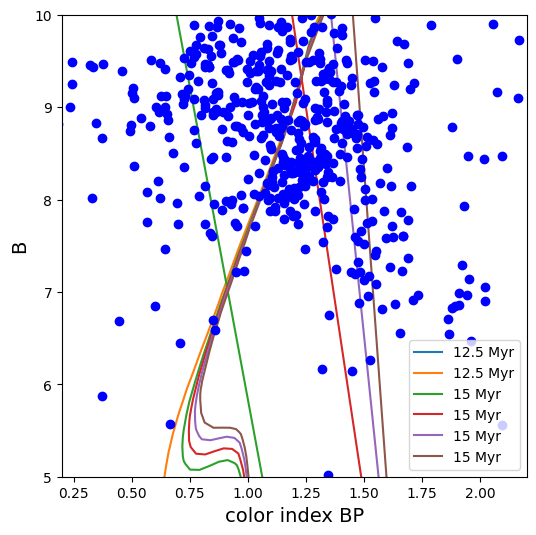

In [40]:
#Let's now plot a model on top of our data, just approximately
fig = plt.figure(figsize=(6,6))
#plt.subplot(121)
plt.errorbar(
    x=m71_new1["BV"],
    y=m71_new1["MB"],
    #xerr=m71_new1["BV_err"],
    #yerr=m71_new1["MB_err"],
    fmt='o', ecolor='blue', elinewidth=1, capsize=5,c='blue'
)
#plt.ylim(21,2)
plt.xlabel('color index BP',fontsize=14)
plt.ylabel('B',fontsize=14)

#Important: isochrones are given in absolute magnitudes, while the data come in apparent
#median_parallax=np.nanmedian(data['parallax'])
#dist=1000/median_parallax #Important: This distance here is just for demonstration (approximate), we will use a different method o determine it
#DM=5*np.log10(dist)-5 #distance modulus
#print('distance modulus:',DM)
N_MIN = 0
N_MAX = 270
#plt.subplot(122)
plt.plot(isochrones['Bmag'][age_1][N_MIN:N_MAX] - isochrones['Vmag'][age_1][N_MIN:N_MAX], isochrones['Bmag'][age_1][N_MIN:N_MAX],label='12.5 Myr')
plt.plot(isochrones['Bmag'][age_2][N_MIN:N_MAX] - isochrones['Vmag'][age_2][N_MIN:N_MAX], isochrones['Bmag'][age_2][N_MIN:N_MAX],label='12.5 Myr')
plt.plot(isochrones['Bmag'][age_3][N_MIN:N_MAX] - isochrones['Vmag'][age_3][N_MIN:N_MAX], isochrones['Bmag'][age_3][N_MIN:N_MAX],label='15 Myr')
plt.plot(isochrones['Bmag'][age_4][N_MIN:N_MAX] - isochrones['Vmag'][age_4][N_MIN:N_MAX], isochrones['Bmag'][age_4][N_MIN:N_MAX],label='15 Myr')
plt.plot(isochrones['Bmag'][age_5][N_MIN:N_MAX] - isochrones['Vmag'][age_5][N_MIN:N_MAX], isochrones['Bmag'][age_5][N_MIN:N_MAX],label='15 Myr')
plt.plot(isochrones['Bmag'][age_6][N_MIN:N_MAX] - isochrones['Vmag'][age_6][N_MIN:N_MAX], isochrones['Bmag'][age_6][N_MIN:N_MAX],label='15 Myr')
plt.xlim(0.2, 2.2)  # Set the x-axis range
plt.ylim(5, 10)
#plt.tight_layout()
plt.legend()
plt.show()
#print(dist)

0.2366210621877213 (0, 1)
*** Best fit model: age =  100.0 Myr; distance= 200 pc


Text(0, 0.5, 'age in Gyr')

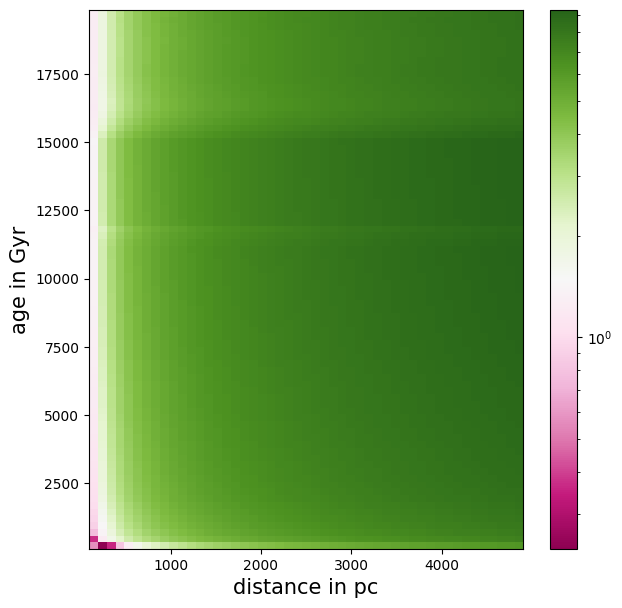

In [41]:
#all the ages that we will test
ages=np.unique(isochrones['logAge'])
N_MIN = 0
N_MAX = 250
#distance
dmin,dmax,step=100,5000,100
distances = np.arange(dmin,dmax,step)
#define an array to save the root-mean-square deviation values
rmsd=np.zeros(shape=(len(ages),len(distances)))
for i in range(len(ages)):
    age=ages[i]
    for j in range(len(distances)):

        ## model
        distance=distances[j]
        DM=5*np.log10(distance)-5 #distance modulus
        isochrone=isochrones[isochrones['logAge'] == age][N_MIN:N_MAX]
        col_iso = isochrone['Bmag'] - isochrone['Vmag'] #color isochrone
        mag_iso = isochrone['Vmag'] + DM #magnitude isochrone, shifted to the distance of the cluster
        line = LineString(np.asarray([col_iso,mag_iso]).T) #Representation of the isochrone as a continuous line

        ## data
        d=np.empty(len(data))
        for k in range(len(data)):

            col_data=m71_new1['BV'][k]

            mag_data=m71_new1['MV'][k]

            point=Point(col_data,mag_data)
            d[k] = point.distance(line) #shortest distance of the point to the line of the isochrone
        rmsd[i,j]=np.sqrt(np.nanmean(d)**2)

fig,ax = plt.subplots(figsize=(7,7))
pos=ax.imshow(rmsd,cmap='PiYG', norm=LogNorm(),origin='lower',
               extent=[distances[0],distances[-1],10**ages[0]/1e6,10**ages[-1]/1e6],aspect='auto')
fig.colorbar(pos, ax=ax)#,format= "%d")

#Find the grid position of the minimum rmsd
minrmsd_pos=np.unravel_index(rmsd.argmin(), rmsd.shape)
print(np.nanmin(rmsd),minrmsd_pos)
print("*** Best fit model: age = ", np.round(10**ages[minrmsd_pos[0]]/1e6),'Myr; distance=',distances[minrmsd_pos[1]],'pc')
best_age=ages[minrmsd_pos[0]]
best_dist=distances[minrmsd_pos[1]]
plt.xlabel('distance in pc',fontsize=15)
plt.ylabel('age in Gyr',fontsize=15)

# Find Age of Cluster (here we are not fitting distances)

*** Best fit model: age = 14.850121262108392 Gyr


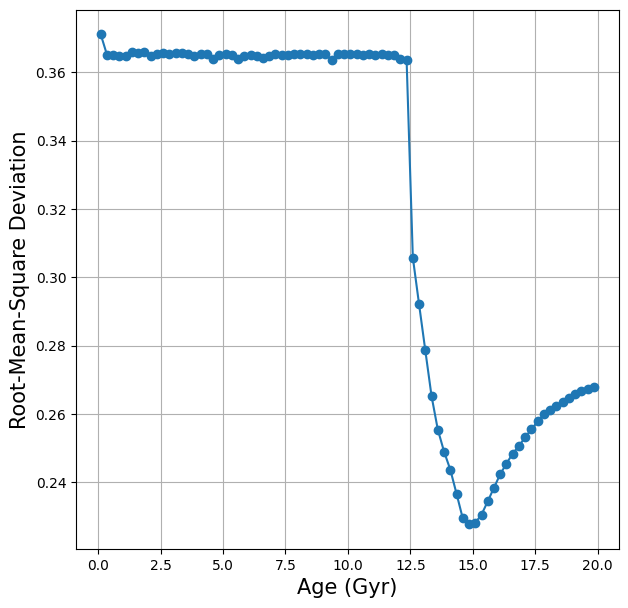

In [42]:
# All the ages that we will test
ages = np.unique(isochrones['logAge'])
N_MIN = 0
N_MAX = 250


rmsd = np.zeros(shape=(len(ages)))

for i in range(len(ages)):
    age = ages[i]

    # Model
    isochrone = isochrones[isochrones['logAge'] == age][N_MIN:N_MAX]
    col_iso = isochrone['Bmag'] - isochrone['Vmag']  # Color isochrone
    mag_iso = isochrone['Vmag']  # Magnitude isochrone

    line = LineString(np.asarray([col_iso, mag_iso]).T)  # Representation of the isochrone as a continuous line

    # Data
    d = np.empty(len(m71_new1))
    for k in range(len(m71_new1)):
        col_data = m71_new1['BV'][k]
        mag_data = m71_new1['MV'][k]
        point = Point(col_data, mag_data)
        d[k] = point.distance(line)  # Shortest distance of the point to the line of the isochrone

    rmsd[i] = np.sqrt(np.nanmean(d) ** 2)

# Plot RMSD values against ages
plt.figure(figsize=(7, 7))
plt.plot(10 ** ages / 1e9, rmsd, marker='o', linestyle='-')
plt.xlabel('Age (Gyr)', fontsize=15)
plt.ylabel('Root-Mean-Square Deviation', fontsize=15)
plt.grid(True)

# Find the age corresponding to the minimum RMSD
best_age = 10 ** ages[rmsd.argmin()] / 1e9
print(f"*** Best fit model: age = {best_age} Gyr")